In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import importlib
from datetime import datetime, timedelta

is_on_colab = False

In [2]:
import Hypers
importlib.reload(Hypers)
import utils
importlib.reload(utils)
import Trainer
importlib.reload(Trainer)
from CompustatExtractor import CompustatExtractor

utils.fix_random_seed(Hypers.Config.seed)

if is_on_colab:
  Hypers.Config.base_path = os.getcwd()
  Hypers.Config.data_path = os.path.join(Hypers.Config.base_path, "data")
  Hypers.Config.model_path = os.path.join(Hypers.Config.base_path, "model")
  Hypers.Config.log_path = os.path.join(Hypers.Config.base_path, "log")

print(f"{Hypers.Config.base_path=}")
print(f"{Hypers.Config.data_path=}")
print(f"{Hypers.Config.model_path=}")
print(f"{Hypers.Config.log_path=}")

Hypers.Config.base_path='d:\\Document\\Ucla-doc\\263\\project\\PNC_Capstone'
Hypers.Config.data_path='d:\\Document\\Ucla-doc\\263\\project\\PNC_Capstone\\data'
Hypers.Config.model_path='d:\\Document\\Ucla-doc\\263\\project\\PNC_Capstone\\model'
Hypers.Config.log_path='d:\\Document\\Ucla-doc\\263\\project\\PNC_Capstone\\log'


In [3]:
suffix = "RetInd_4"

## LSTM

In [4]:
import LSTMDataset
importlib.reload(LSTMDataset)
import LSTMModel
importlib.reload(LSTMModel)

model_type = "Lstm"

### train company by company

In [5]:
train_dict = utils.load_pickle(os.path.join(Hypers.Config.data_path, "train_dict_RetInd_4.pkl"))
test_dict = utils.load_pickle(os.path.join(Hypers.Config.data_path, "test_dict_RetInd_4.pkl"))
print(f"{len(train_dict)}", f"{len(test_dict)}")

# max_seq_len = max(max([len(entries) for entries in train_dict.values()]), max([len(entries) for entries in test_dict.values()]))
max_seq_len = 2
print(f"{max_seq_len=}")

model = LSTMModel.LSTMModel(input_size=96,
                                      hidden_size=Hypers.Config.hidden_size,
                                      num_layers=max_seq_len,
                                      proj_size=Hypers.Config.proj_size)
criterion = nn.MSELoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=Hypers.Config.learning_rate)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

263 76
max_seq_len=2


In [6]:
model

LSTMModel(
  (lstm): LSTM(96, 256, num_layers=2, batch_first=True, dropout=0.2)
  (linear): Linear(in_features=256, out_features=1, bias=True)
)

In [7]:
train_set, test_set = LSTMDataset.LSTMDataset(train_dict), LSTMDataset.LSTMDataset(test_dict)
train_loader = DataLoader(train_set, batch_size=Hypers.Config.batch_size, shuffle=True, collate_fn=LSTMDataset.LSTMDataset.custom_collate_fn)
test_loader = DataLoader(test_set, batch_size=Hypers.Config.batch_size, shuffle=True, collate_fn=LSTMDataset.LSTMDataset.custom_collate_fn)

# trainer = Trainer.Trainer(model, criterion, optimizer, device, train_loader, test_loader, max_seq_len)
# train_loss, train_accuracy, test_loss, test_accuracy = trainer.train_loop()
# utils.plot_graph(train_loss, train_accuracy, test_loss, test_accuracy, identifier=f"{model_type}_{suffix}")

In [8]:
for batch in train_loader:
    features, labels, mask = batch
    print(features.shape, labels.shape, mask.shape)
    break

torch.Size([32, 28, 96]) torch.Size([32, 28]) torch.Size([32, 28])


### train data by data

In [5]:
def convert_labels_to_int(merged_dict):
    for company, quarters in merged_dict.items():
        for quarter, (features, label) in quarters.items():
            # 将标签从浮点数转换为整数
            new_label = label.int()
            merged_dict[company][quarter] = (features, new_label)
    return merged_dict

def get_unique_labels(merged_dict):
    unique_labels = set()
    
    for company, quarters in merged_dict.items():
        for quarter, (_, label) in quarters.items():
            unique_labels.add(label.item())  # 使用 item() 方法将张量转换为 Python 数值
    
    return unique_labels

In [6]:
# Optional: Split data into train and test
# You have to run this cell if you changed your feature,rating dataset
merged_dict = utils.load_pickle(os.path.join(Hypers.Config.data_path, "single_data.pkl"))
merged_dict = convert_labels_to_int(merged_dict)
train_dict, test_dict = utils.spilt_train_valid(merged_dict, random_select=True, save=False, suffix=suffix)
print(len(train_dict), len(test_dict))

595 171


In [7]:
unique_labels = get_unique_labels(merged_dict)
print("Unique labels:", unique_labels)
print("Number of unique labels:", len(unique_labels))

Unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 22, 23}
Number of unique labels: 22


In [8]:
# max_seq_len = max(max([len(entries) for entries in train_dict.values()]), max([len(entries) for entries in test_dict.values()]))
max_seq_len = 2
print(f"{max_seq_len=}")

model = LSTMModel.LSTMModel(input_size=24,
                                      hidden_size=Hypers.Config.hidden_size,
                                      num_layers=max_seq_len,
                                      proj_size=Hypers.Config.proj_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=Hypers.Config.learning_rate)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

max_seq_len=2


In [9]:
model

LSTMModel(
  (lstm): LSTM(24, 256, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=256, out_features=24, bias=True)
)

Validating Epoch 499: 100%|██████████| 500/500 [00:40<00:00, 12.28it/s, Validation Loss: 8.069, Accuracy: 0.213] 


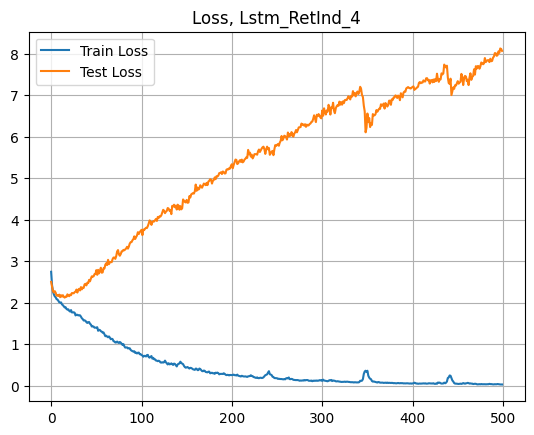

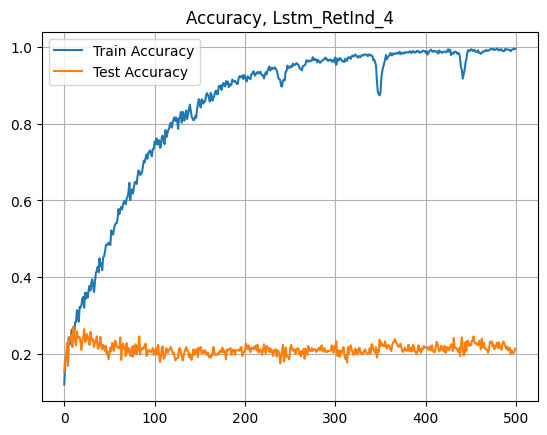

In [10]:
train_set, test_set = LSTMDataset.LSTMDataset(train_dict), LSTMDataset.LSTMDataset(test_dict)
train_loader = DataLoader(train_set, batch_size=Hypers.Config.batch_size, shuffle=True, collate_fn=LSTMDataset.LSTMDataset.custom_collate_fn)
test_loader = DataLoader(test_set, batch_size=Hypers.Config.batch_size, shuffle=True, collate_fn=LSTMDataset.LSTMDataset.custom_collate_fn)

trainer = Trainer.Trainer(model, criterion, optimizer, device, train_loader, test_loader, max_seq_len)
train_loss, train_accuracy, test_loss, test_accuracy = trainer.train_loop()
utils.plot_graph(train_loss, train_accuracy, test_loss, test_accuracy, identifier=f"{model_type}_{suffix}")